In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data

In [3]:
BMMC = sp.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [4]:
print(f"The data has {BMMC.n_obs} observations and {BMMC.n_vars} features.")

The data has 69249 observations and 129921 features.


In [5]:
BMMC

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Train/Test Split

We choose one donor to train on (te reduce individual biological differences)

In [7]:
BMMC.obs.drop_duplicates(subset=["DonorID"], keep='first').reset_index()[["Site","DonorID","DonorAge","DonorBMI","DonorBloodType","DonorRace","Ethnicity","DonorGender","QCMeds","DonorSmoker"]].set_index('DonorID').sort_values(by=['DonorID'])

,Site,DonorAge,DonorBMI,DonorBloodType,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker
DonorID,,,,,,,,,
10886,site1,35,28.6,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker
11466,site3,22,31.5,A+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker
12710,site2,27,32.1,O+,White,NOT HISPANIC OR LATINO,Male,False,Nonsmoker
13272,site4,35,31.0,O+,Other Race,HISPANIC OR LATINO,Male,False,Nonsmoker
15078,site1,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker
16710,site2,40,27.8,O+,White,HISPANIC OR LATINO,Female,False,Smoker
18303,site1,33,24.0,O+,Asian,NOT HISPANIC OR LATINO,Male,False,Smoker
19593,site4,31,32.6,A+,Black or African American,NOT HISPANIC OR LATINO,Male,False,Nonsmoker
28045,site3,36,23.8,A+,Other Race,HISPANIC OR LATINO,Female,False,Nonsmoker


69249 samples of 10 donors


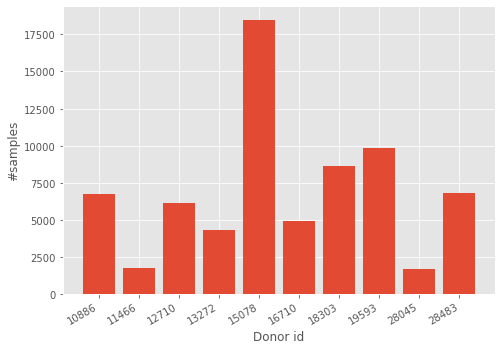

In [8]:
donors, donor_sample_count = np.unique(BMMC.obs['DonorID'], return_counts=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(donor_sample_count)} samples of {len(donors)} donors")
ax.bar(list(map(str, donors)), donor_sample_count)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Donor id")
plt.ylabel("#samples")
plt.show()

## Single Donor

In [9]:
donor_idx = 15078 # most samples

donor_filter = BMMC.obs['DonorID'] == donor_idx
n_samples = np.sum(donor_filter)

print(f"{n_samples} samples")

18467 samples


In [12]:
# Random 70-30 split
train_percentage = 0.7

np.random.seed(seed)
train_samples_idx = np.random.choice(n_samples, int(n_samples*train_percentage), replace=False)
test_samples_idx = np.delete(np.arange(n_samples), train_samples_idx)

X_test_single = BMMC.obsm['ATAC_gene_activity'][donor_filter][test_samples_idx]
X_train_single = BMMC.obsm['ATAC_gene_activity'][donor_filter][train_samples_idx]

Y_test_single = BMMC.obs['cell_type'][donor_filter][test_samples_idx]
Y_train_single = BMMC.obs['cell_type'][donor_filter][train_samples_idx]

In [14]:
Y_train_single

AGAGAAGCAATAGTCT-13-s4d1     Proerythroblast
CCGCTTAGTTCCGGCT-1-s1d1     CD4+ T activated
GTCCATTGTGGGTACT-13-s4d1    CD4+ T activated
GCTGATCCACCTAATG-1-s1d1           CD14+ Mono
CTTCAAGCAATAACGA-1-s1d1           CD14+ Mono
                                  ...       
TTCATTCAGCTTTGTT-13-s4d1         Plasma cell
TTCACTGTCTAGCGAT-4-s2d1         Erythroblast
ATTAGCTCATGAATCT-1-s1d1         Erythroblast
ACTGAATGTATACTGG-13-s4d1                  NK
TTTGTTGGTCCACAAA-4-s2d1        Naive CD20+ B
Name: cell_type, Length: 12926, dtype: category
Categories (22, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

## Multiple Donors

69249 samples of 10 donors


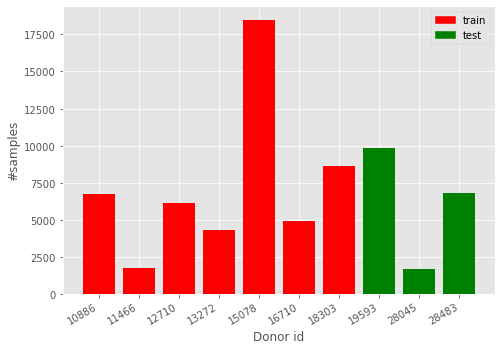

In [15]:
donors, donor_sample_count = np.unique(BMMC.obs['DonorID'], return_counts=True)
color = ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'green', 'green', 'green']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(donor_sample_count)} samples of {len(donors)} donors")
ax.bar(list(map(str, donors)), donor_sample_count, color=color)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Donor id")
plt.ylabel("#samples")
colors = {'train':'red', 'test':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

In [16]:
test_donors_idx = [19593, 28045, 28483]
test_filter = np.isin(BMMC.obs['DonorID'], test_donors_idx)
train_filter = np.invert(test_filter)

n_train = np.sum(train_filter)
n_test = np.sum(test_filter)
print(f"{n_train} train samples\n{n_test} test samples\n{n_train/(n_train+n_test)*100:.2f}% of samples used for training")

50913 train samples
18336 test samples
73.52% of samples used for training


In [17]:
X_test_multiple = BMMC.obsm['ATAC_gene_activity'][test_filter]
X_train_multiple = BMMC.obsm['ATAC_gene_activity'][train_filter]

Y_test_multiple = BMMC.obs['cell_type'][test_filter]
Y_train_multiple = BMMC.obs['cell_type'][train_filter]

# Model Analysis

In [26]:
# load models
with open('../models/BMMC/lsvm_best_model_singledonor.pkl', 'rb') as f:
    single_donor_model = pickle.load(f)
    
with open('../models/BMMC/lsvm_atac_model.pkl', 'rb') as f:
    multiple_donor_model = pickle.load(f)

In [27]:
single_donor_test_predictions_single = single_donor_model.predict(X_test_single)
single_donor_test_predictions_multiple = single_donor_model.predict(X_test_multiple)

multiple_donor_test_predictions_single = multiple_donor_model.predict(X_test_single)
multiple_donor_test_predictions_multiple = multiple_donor_model.predict(X_test_multiple)

In [30]:
from sklearn.metrics import accuracy_score

print("Single Donor Model:")
print(f"X_test_single accuracy: {accuracy_score(Y_test_single, single_donor_test_predictions_single)}")
print(f"X_test_multiple accuracy: {accuracy_score(Y_test_multiple, single_donor_test_predictions_multiple)}")
print()
print("Multiple Donor Model:")
print(f"X_test_single accuracy: {accuracy_score(Y_test_single, multiple_donor_test_predictions_single)}")
print(f"X_test_multiple accuracy: {accuracy_score(Y_test_multiple, multiple_donor_test_predictions_multiple)}")

Single Donor Model:
X_test_single accuracy: 0.8846778559826746
X_test_multiple accuracy: 0.818880890052356

Multiple Donor Model:
X_test_single accuracy: 0.954340371774048
X_test_multiple accuracy: 0.8331697207678883


In [31]:
from sklearn.metrics import balanced_accuracy_score

print("Single Donor Model:")
print(f"X_test_single balanced accuracy: {balanced_accuracy_score(Y_test_single, single_donor_test_predictions_single)}")
print(f"X_test_multiple balanced accuracy: {balanced_accuracy_score(Y_test_multiple, single_donor_test_predictions_multiple)}")
print()
print("Multiple Donor Model:")
print(f"X_test_single balanced accuracy: {balanced_accuracy_score(Y_test_single, multiple_donor_test_predictions_single)}")
print(f"X_test_multiple balanced accuracy: {balanced_accuracy_score(Y_test_multiple, multiple_donor_test_predictions_multiple)}")

Single Donor Model:
X_test_single balanced accuracy: 0.7713595311871705
X_test_multiple balanced accuracy: 0.7213093299528225

Multiple Donor Model:
X_test_single balanced accuracy: 0.8979723628446711
X_test_multiple balanced accuracy: 0.7281373214856022
